# Fetching the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"basilkjose","key":"72e1fa5852c41dda869dfa76f1a41c0e"}'}

In [2]:
#data is downloaded using kaggle API
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c reducing-commercial-aviation-fatalities

 99% 1.65G/1.67G [00:12<00:00, 125MB/s]
100% 1.67G/1.67G [00:12<00:00, 147MB/s]
 68% 28.0M/41.2M [00:00<00:00, 150MB/s]
100% 41.2M/41.2M [00:00<00:00, 142MB/s]
 96% 417M/435M [00:03<00:00, 106MB/s]
100% 435M/435M [00:03<00:00, 138MB/s]


In [3]:
#unzipping all the downloaded files
!unzip \*.zip  && rm *.zip

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

3 archives were successfully processed.


In [2]:
# importing neccessary libraries
import numpy as np
import pandas as pd 
import sklearn 
import os
import matplotlib.pyplot as plt
import zipfile
import tqdm 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy

# Reading the data

In [12]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
print('Train Data Shape ---->',train_data.shape)
print("\n")
print('Test Data Shape ----->',test_data.shape)

Train Data Shape ----> (4867421, 28)


Test Data Shape -----> (17965143, 28)


In [18]:
print("-------Train Data------\n")
train_data.head()

-------Train Data------



,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [15]:
print("-------Train Data------\n")
train_data.info()

-------Train Data------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
 #   Column      Dtype  
---  ------      -----  
 0   crew        int64  
 1   experiment  object 
 2   time        float64
 3   seat        int64  
 4   eeg_fp1     float64
 5   eeg_f7      float64
 6   eeg_f8      float64
 7   eeg_t4      float64
 8   eeg_t6      float64
 9   eeg_t5      float64
 10  eeg_t3      float64
 11  eeg_fp2     float64
 12  eeg_o1      float64
 13  eeg_p3      float64
 14  eeg_pz      float64
 15  eeg_f3      float64
 16  eeg_fz      float64
 17  eeg_f4      float64
 18  eeg_c4      float64
 19  eeg_p4      float64
 20  eeg_poz     float64
 21  eeg_c3      float64
 22  eeg_cz      float64
 23  eeg_o2      float64
 24  ecg         float64
 25  r           float64
 26  gsr         float64
 27  event       object 
dtypes: float64(24), int64(2), object(2)
memory usage: 1.0+ GB


In [16]:
print("-------Test Data------\n")
test_data.head()

-------Test Data------



,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,...,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,...,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,...,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,...,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,...,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


In [17]:
print("-------Test Data------\n")
test_data.info()

-------Test Data------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17965143 entries, 0 to 17965142
Data columns (total 28 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          int64  
 1   crew        int64  
 2   experiment  object 
 3   time        float64
 4   seat        int64  
 5   eeg_fp1     float64
 6   eeg_f7      float64
 7   eeg_f8      float64
 8   eeg_t4      float64
 9   eeg_t6      float64
 10  eeg_t5      float64
 11  eeg_t3      float64
 12  eeg_fp2     float64
 13  eeg_o1      float64
 14  eeg_p3      float64
 15  eeg_pz      float64
 16  eeg_f3      float64
 17  eeg_fz      float64
 18  eeg_f4      float64
 19  eeg_c4      float64
 20  eeg_p4      float64
 21  eeg_poz     float64
 22  eeg_c3      float64
 23  eeg_cz      float64
 24  eeg_o2      float64
 25  ecg         float64
 26  r           float64
 27  gsr         float64
dtypes: float64(24), int64(3), object(1)
memory usage: 3.7+ GB


# EDA (Exploratory Data Analysis)

* A = Baseline
* B = Startle/Surprise(SS)
* C = Channelized Attention(CA)
* D = Diverted  Attention(DA)

In [19]:
print("-------Train Data------\n")
train_data.columns

-------Train Data------



Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr', 'event'],
      dtype='object')

In [20]:
print("-------Test Data------\n")
test_data.columns

-------Test Data------



Index(['id', 'crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7',
       'eeg_f8', 'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1',
       'eeg_p3', 'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4',
       'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr'],
      dtype='object')

In [25]:
print("-------Train Data------")
train_data.describe().transpose()

-------Train Data------


,count,mean,std,min,25%,50%,75%,max
crew,4867421.0,5.538783,3.409353,1.000000,3.000000,5.000000,7.000000,13.000000
time,4867421.0,178.235843,103.959165,0.003000,88.081001,176.929688,268.339844,360.371094
seat,4867421.0,0.499953,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
eeg_fp1,4867421.0,3.746336,45.067626,-1361.359985,-9.200250,0.381902,10.306100,1972.239990
eeg_f7,4867421.0,1.360002,35.189228,-1581.329956,-8.325150,0.042641,8.753340,2048.790039
eeg_f8,4867421.0,1.213644,35.192423,-1643.949951,-8.767610,0.114039,9.282560,2145.709961
eeg_t4,4867421.0,0.073509,24.314724,-1516.640015,-7.367240,0.000000,7.437780,1731.880005
eeg_t6,4867421.0,0.078455,18.039315,-1220.510010,-6.102000,0.000000,6.176630,900.937012
eeg_t5,4867421.0,0.086755,18.326063,-1266.430054,-6.007260,0.000000,6.086460,1176.540039
eeg_t3,4867421.0,0.229991,25.311318,-1279.939941,-6.904030,0.000000,7.071460,1514.819946


In [26]:
print("-------Test Data------")
test_data.describe().transpose()

-------Test Data------


,count,mean,std,min,25%,50%,75%,max
id,17965143.0,8.982571e+06,5.186090e+06,0.000000,4.491286e+06,8.982571e+06,1.347386e+07,1.796514e+07
crew,17965143.0,5.240582e+00,3.408746e+00,1.000000,2.000000e+00,5.000000e+00,7.000000e+00,1.300000e+01
time,17965143.0,1.972621e+03,1.168732e+03,0.000000,9.746914e+02,1.949363e+03,2.924035e+03,4.917688e+03
seat,17965143.0,4.999695e-01,5.000000e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
eeg_fp1,17965143.0,5.938414e+00,1.838633e+02,-4629.899902,-2.105640e+01,8.436010e-01,2.475940e+01,4.751060e+03
eeg_f7,17965143.0,2.650973e+00,1.746916e+02,-4635.799805,-1.958760e+01,2.468260e-01,2.129610e+01,4.637460e+03
eeg_f8,17965143.0,1.394608e+00,1.739371e+02,-4629.850098,-1.974340e+01,4.586300e-01,2.182585e+01,4.756000e+03
eeg_t4,17965143.0,-2.414278e-01,1.652322e+02,-4632.290039,-1.629735e+01,1.185930e-01,1.684330e+01,4.729170e+03
eeg_t6,17965143.0,9.435666e-01,1.992847e+02,-4641.779785,-1.327720e+01,1.608800e-02,1.372060e+01,4.744630e+03
eeg_t5,17965143.0,2.230059e-01,1.665552e+02,-4619.529785,-1.275970e+01,1.115720e-01,1.345290e+01,4.713360e+03


### Duplicate Checks

In [ ]:
print("Number of duplicate in train dataset : {} ".format(sum(train_data.duplicated())))
print("Number of duplicate in test dataset  : {} ".format(sum(test_data.duplicated())))

Number of duplicate in train dataset : 0 
Number of duplicate in test dataset  : 0 


### Nan/Null Value checks

In [ ]:
print("We have {} NaN/Null values in train dataset ".format(train_data.isnull().values.sum()))
print("We have {} NaN/Null values in test dataset ".format(train_data.isnull().values.sum()))

We have 0 NaN/Null values in train dataset 
We have 0 NaN/Null values in test dataset 


### Analysing the distribution of labels

In [ ]:
train_data['event'].value_counts()

A    2848809
C    1652686
D     235329
B     130597
Name: event, dtype: int64

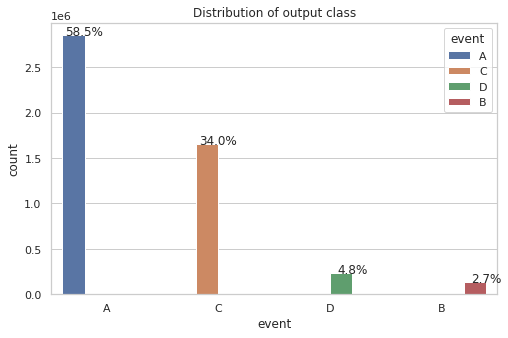

In [ ]:
ax=sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(train_data))
ax = sns.countplot(x="event", hue="event", data=train_data)
plt.title("Distribution of output class")
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

* As we can see from the count, our dataset is imbalanced dataset. Count of event 'SS' is the least and count of event 'A' = baseline is  maximium.So we can conclude that it is a imbalnced dataset.

## Plotting Based Analysis

### Time

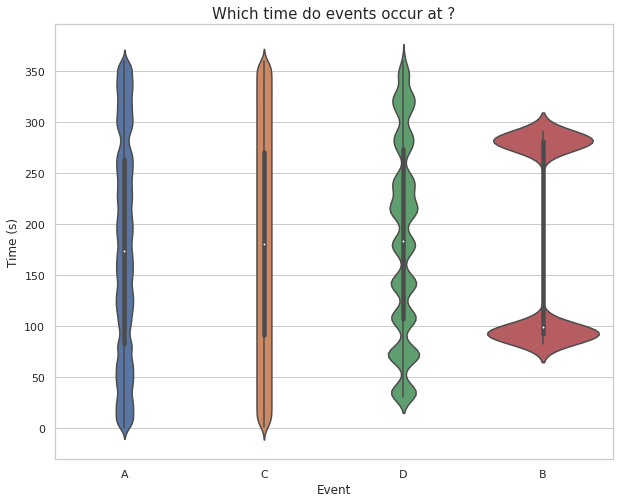

In [ ]:
plt.figure(figsize=(10,8))
sns.violinplot(x='event', y='time', data=train_data)
plt.ylabel("Time (s)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("Which time do events occur at ?", fontsize=15)
plt.show()

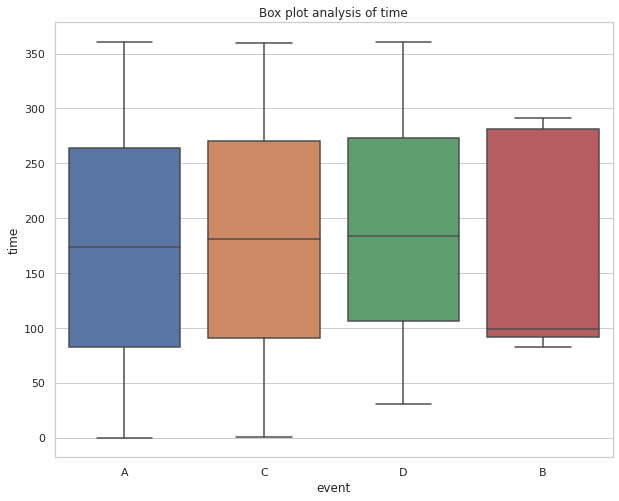

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='event', y='time', data=train_data)
plt.title("Box plot analysis of time")
plt.show()

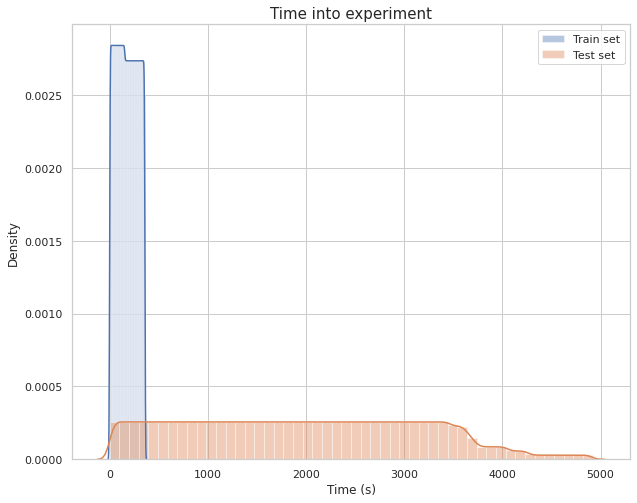

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(train_data['time'], label='Train set')
sns.distplot(test_data['time'], label='Test set')
plt.legend()
plt.xlabel("Time (s)", fontsize=12)
plt.title("Time into experiment", fontsize=15)
plt.show()

* We can see event B's plot tells us that the values of the plot are present in the high and lower range of the time axis and there are very few values in the mid-range.
* For other classes, the time feature is well distributed.
* From the distplot, we can say that Time into the experiment is on an average between 0 to 360 sec.
* From the above plot, we can understand that there is a huge difference in the Train and test time of the experiment.


### ECG

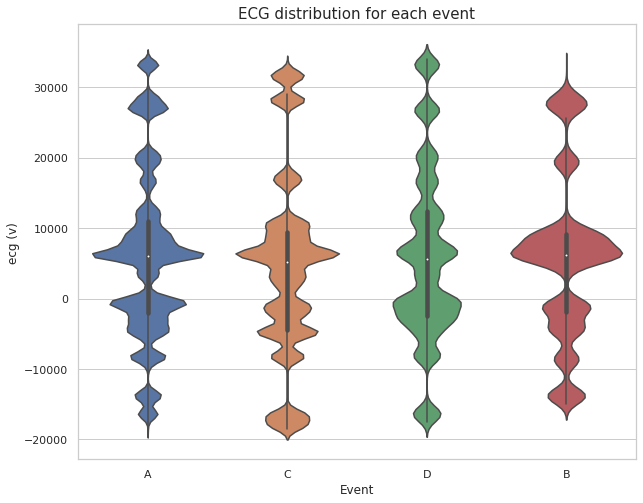

In [ ]:
plt.figure(figsize=(10,8))
sns.violinplot(x='event', y='ecg', data=train_data)
plt.ylabel("ecg (v)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("ECG distribution for each event", fontsize=15)
plt.show()

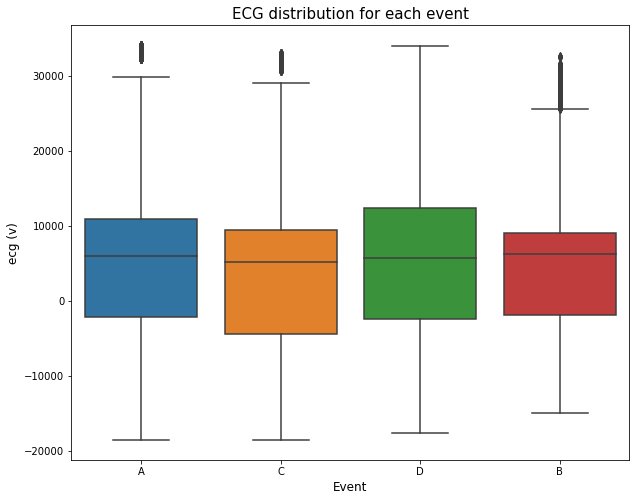

In [8]:
plt.figure(figsize=(10,8))
sns.boxplot(x='event', y='ecg', data=train_data)
plt.ylabel("ecg (v)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("ECG distribution for each event", fontsize=15)
plt.show()

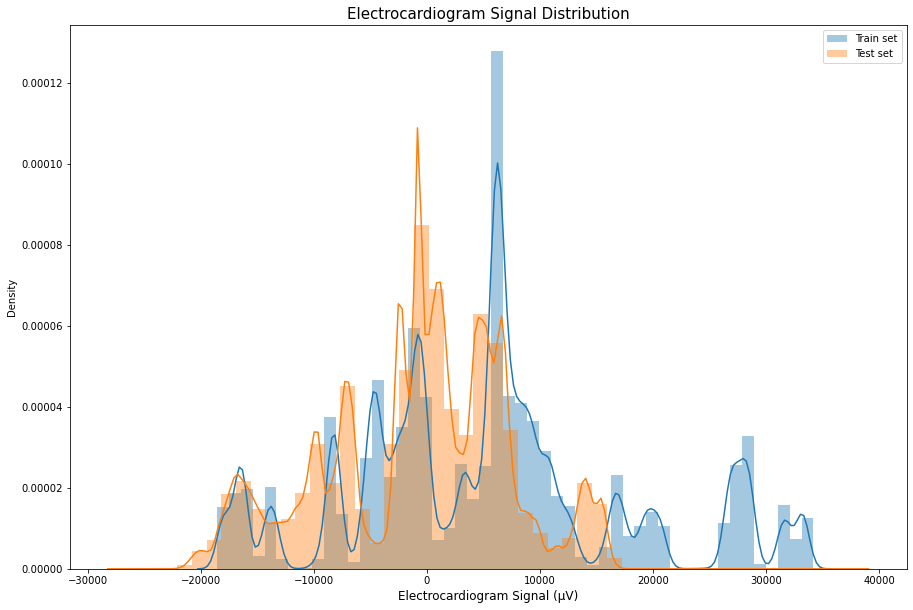

In [9]:
plt.figure(figsize=(15,10))
sns.distplot(train_data['ecg'], label='Train set')
sns.distplot(test_data['ecg'], label='Test set')
plt.legend()
plt.xlabel("Electrocardiogram Signal (µV)", fontsize=12)
plt.title("Electrocardiogram Signal Distribution", fontsize=15)
plt.show()

* Violin plot tells us that for event A there are very few values in between range 22k to 25k uV.For event B there are very few values present between ecg values of 12k to 16k uV .For event C there are very few values between 19k to 25k uV. and -10k to -15k. For event D between -11k to -16k uV ecg microvolts, there are very few values present that's the basic thing which we can observe from the violin plot for ECG.
* From the box plot, it is observed that the ecg data has some outliers. But we cannot simply remove them because these extreme values might be useful in predicting the event. When the value of ECG is high (more than 10000 microvolts), the pilot is more likely to enter into the DA state. Similarly, when the value is too negative, the pilot is likely to be in CA state.
* From the pdf of ECG we can see the range of values for ecg is between the range of -20k to +35k uV (approx). We can see that there are very few values between the 20k to 25k uV range than other values of uV of ECG.


### GSR (Galvanic Skin Response)

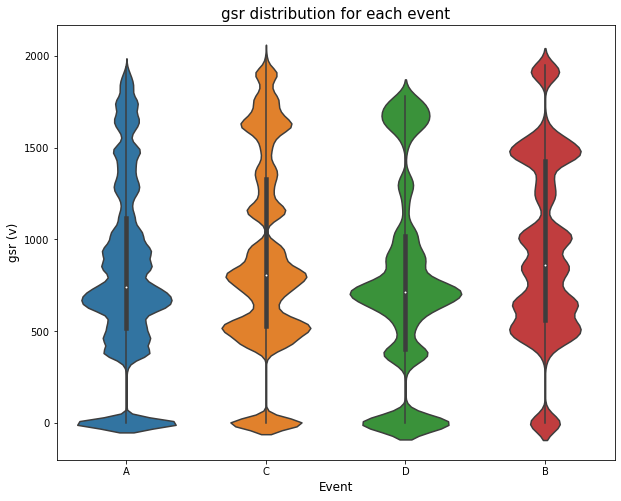

In [10]:
plt.figure(figsize=(10,8))
sns.violinplot(x='event', y='gsr', data=train_data)
plt.ylabel("gsr (v)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("gsr distribution for each event", fontsize=15)
plt.show()

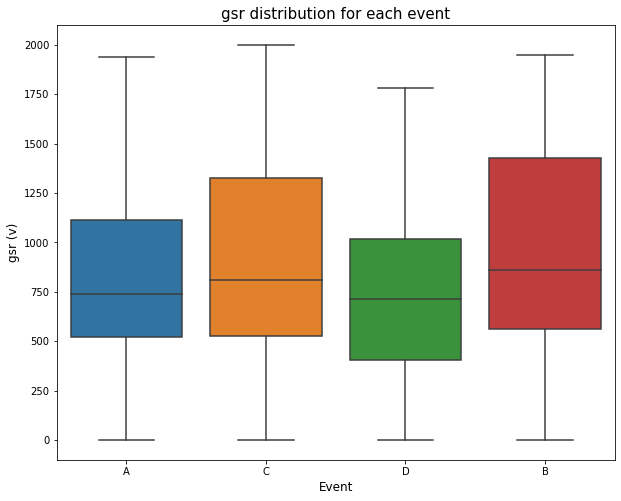

In [11]:
plt.figure(figsize=(10,8))
sns.boxplot(x='event', y='gsr', data=train_data)
plt.ylabel("gsr (v)", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("gsr distribution for each event", fontsize=15)
plt.show()

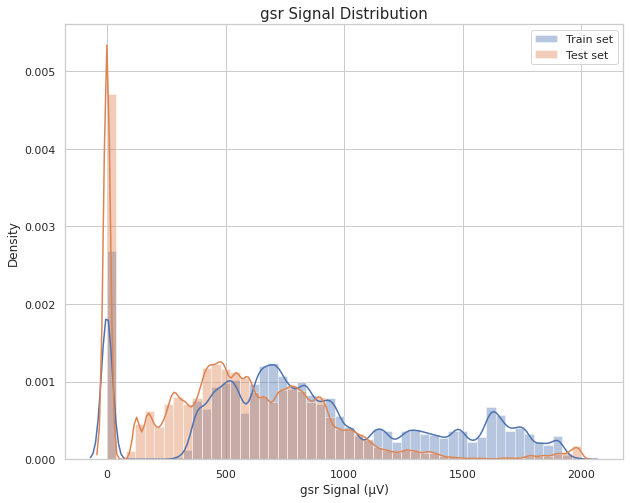

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(train_data['gsr'], label='Train set')
sns.distplot(test_data['gsr'], label='Test set')
plt.legend()
plt.xlabel("gsr Signal (µV)", fontsize=12)
plt.title("gsr Signal Distribution", fontsize=15)
plt.show()

* From the violin plot for each event we can see that for each event there are almost no values of GSR in the range between 50 to 300 uV. Otherwise, distributions are almost of the same type. That means we cant simply place any threshold on the GSR and use it to classify any particular class exclusively.
* The pdf of GSR has a range from 0 to 2000uV approximately.
* GSR has some role in determining the event. For example, if the value from gsr is too high the pilot is more likely to be in SS state. Also if the sensor output is very low, the pilot is probably in DA state

### Respiration

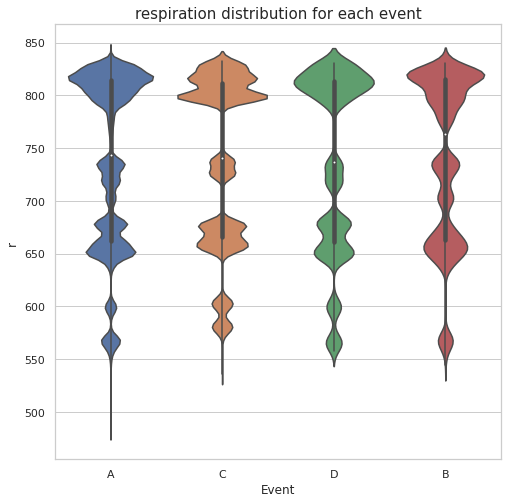

In [ ]:
plt.figure(figsize=(8,8))
sns.violinplot(x='event', y='r', data=train_data)
plt.ylabel("r ", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("respiration distribution for each event", fontsize=15)
plt.show()

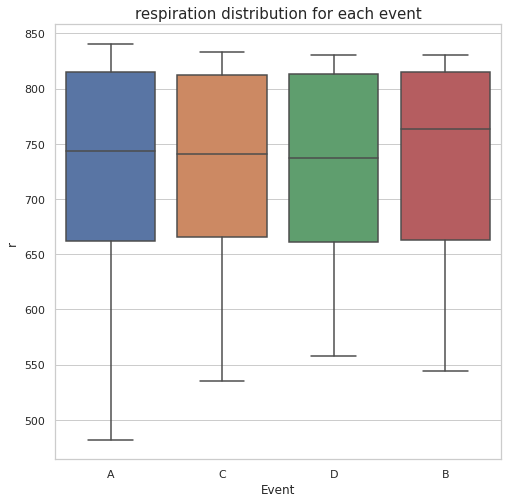

In [ ]:
plt.figure(figsize=(8,8))
sns.boxplot(x='event', y='r', data=train_data)
plt.ylabel("r ", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("respiration distribution for each event", fontsize=15)
plt.show()

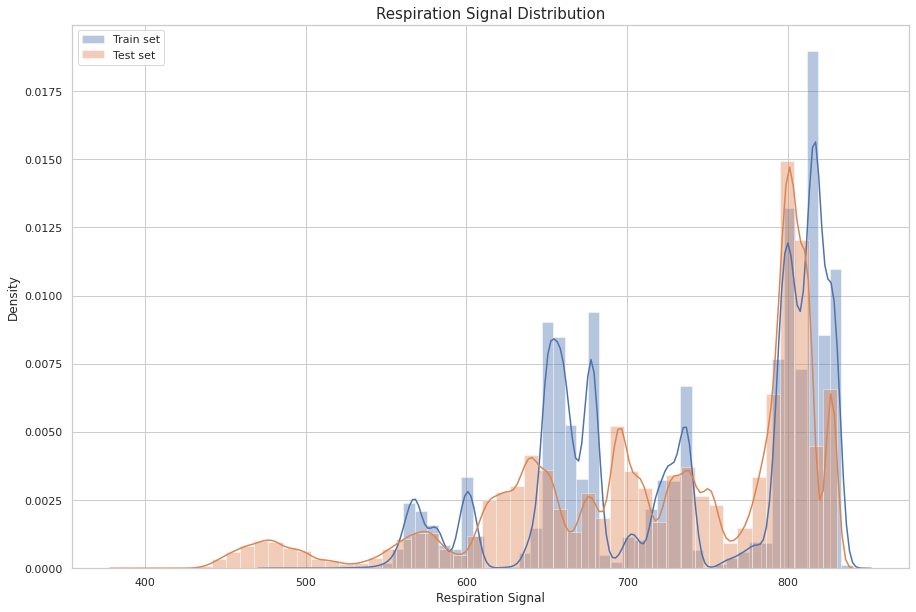

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(train_data['r'], label='Train set')
sns.distplot(test_data['r'], label='Test set')
plt.legend()
plt.xlabel("Respiration Signal", fontsize=12)
plt.title("Respiration Signal Distribution", fontsize=15)
plt.show()

* From the violin plot we can see that there are very few values between 750 to 800 for event C and D and there are few values of event A which are below most of the other event's values
* We can see the same thing for pdf of respiration signal and the range of respiration signal is from 400 to 850 typically.
* This sensor output is not at all separating the events. This might be because of the noise in the data

### Seat

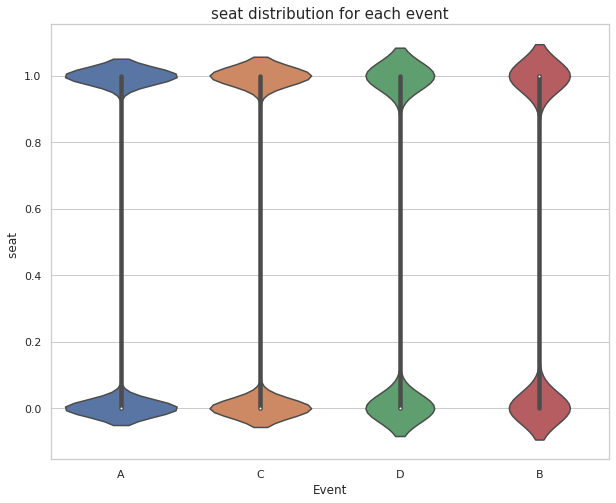

In [ ]:
plt.figure(figsize=(10,8))
sns.violinplot(x='event', y='seat', data=train_data)
plt.ylabel("seat ", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("seat distribution for each event", fontsize=15)
plt.show()

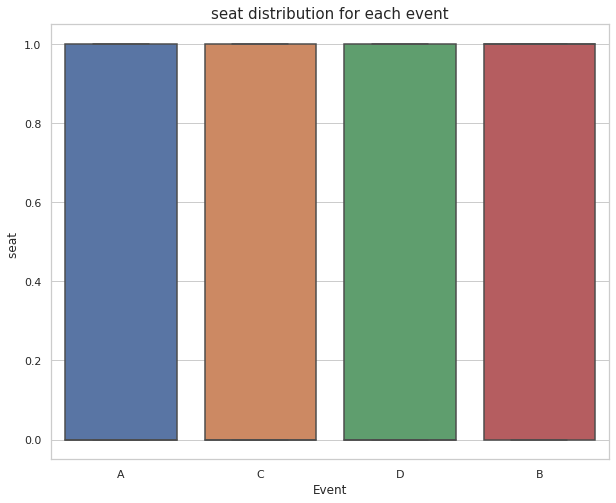

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='event', y='seat', data=train_data)
plt.ylabel("seat ", fontsize=12)
plt.xlabel("Event", fontsize=12)
plt.title("seat distribution for each event", fontsize=15)
plt.show()

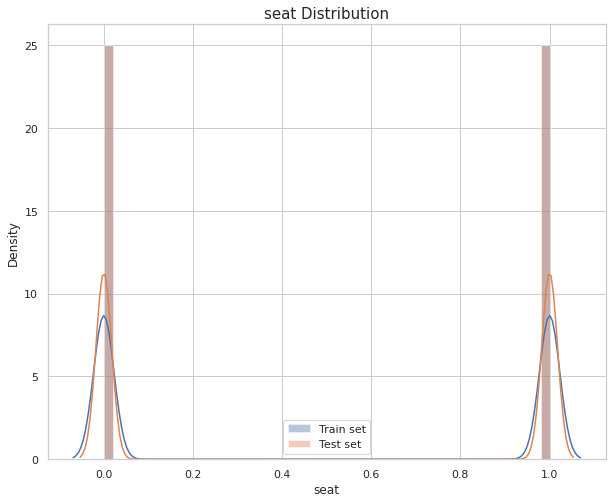

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(train_data['seat'], label='Train set')
sns.distplot(test_data['seat'], label='Test set')
plt.legend()
plt.xlabel("seat", fontsize=12)
plt.title("seat Distribution", fontsize=15)
plt.show()

* We can observe from the seat distribution that the values of the seat are either 0 or 1 rest everywhere its value is 0.

### EEG

* eg_features = "eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"
* since there are 20 eeg features and we are finding its distribution with event so we want 20 plots

In [ ]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1",
                "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

100%|██████████| 20/20 [1:41:07<00:00, 303.36s/it]


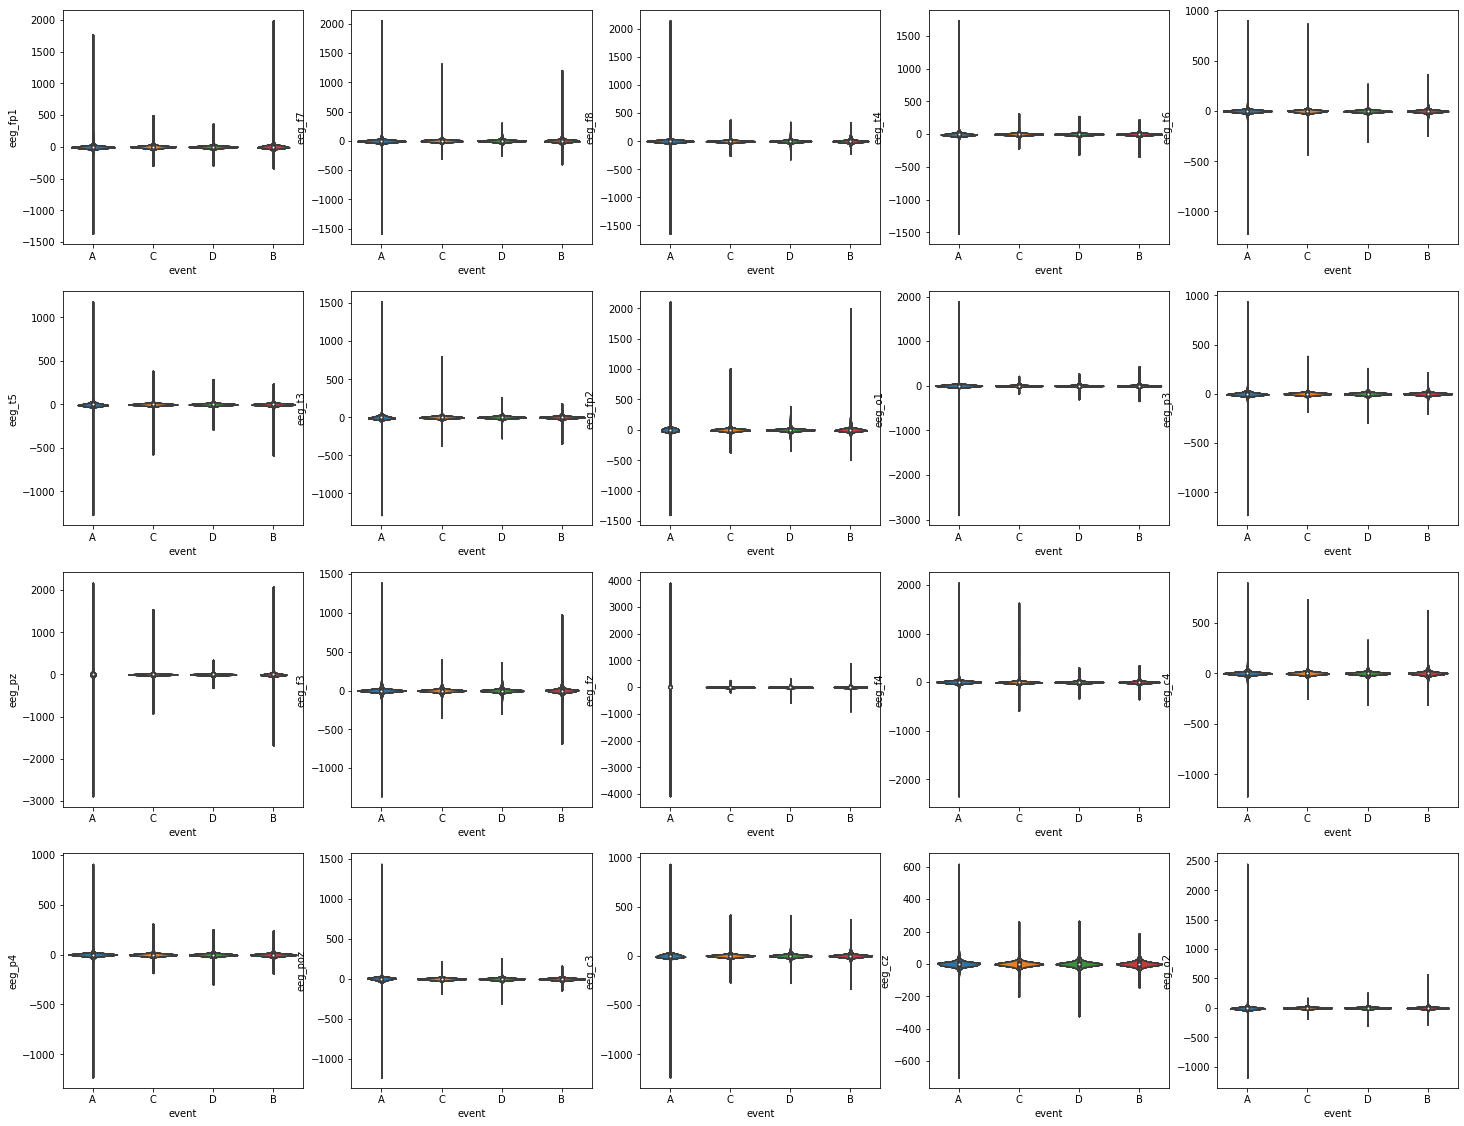

In [ ]:
plt.figure(figsize=(25,25))
plt.title("All EGG Reading Violin Plot ",fontsize=20)
for i in tqdm(range(len(eeg_features))):
  for i,egg in enumerate(eeg_features):
    plt.subplot(5,5,i+1)
    sns.violinplot(x='event',y=egg,data=train_data,showfliers=False)
plt.show()

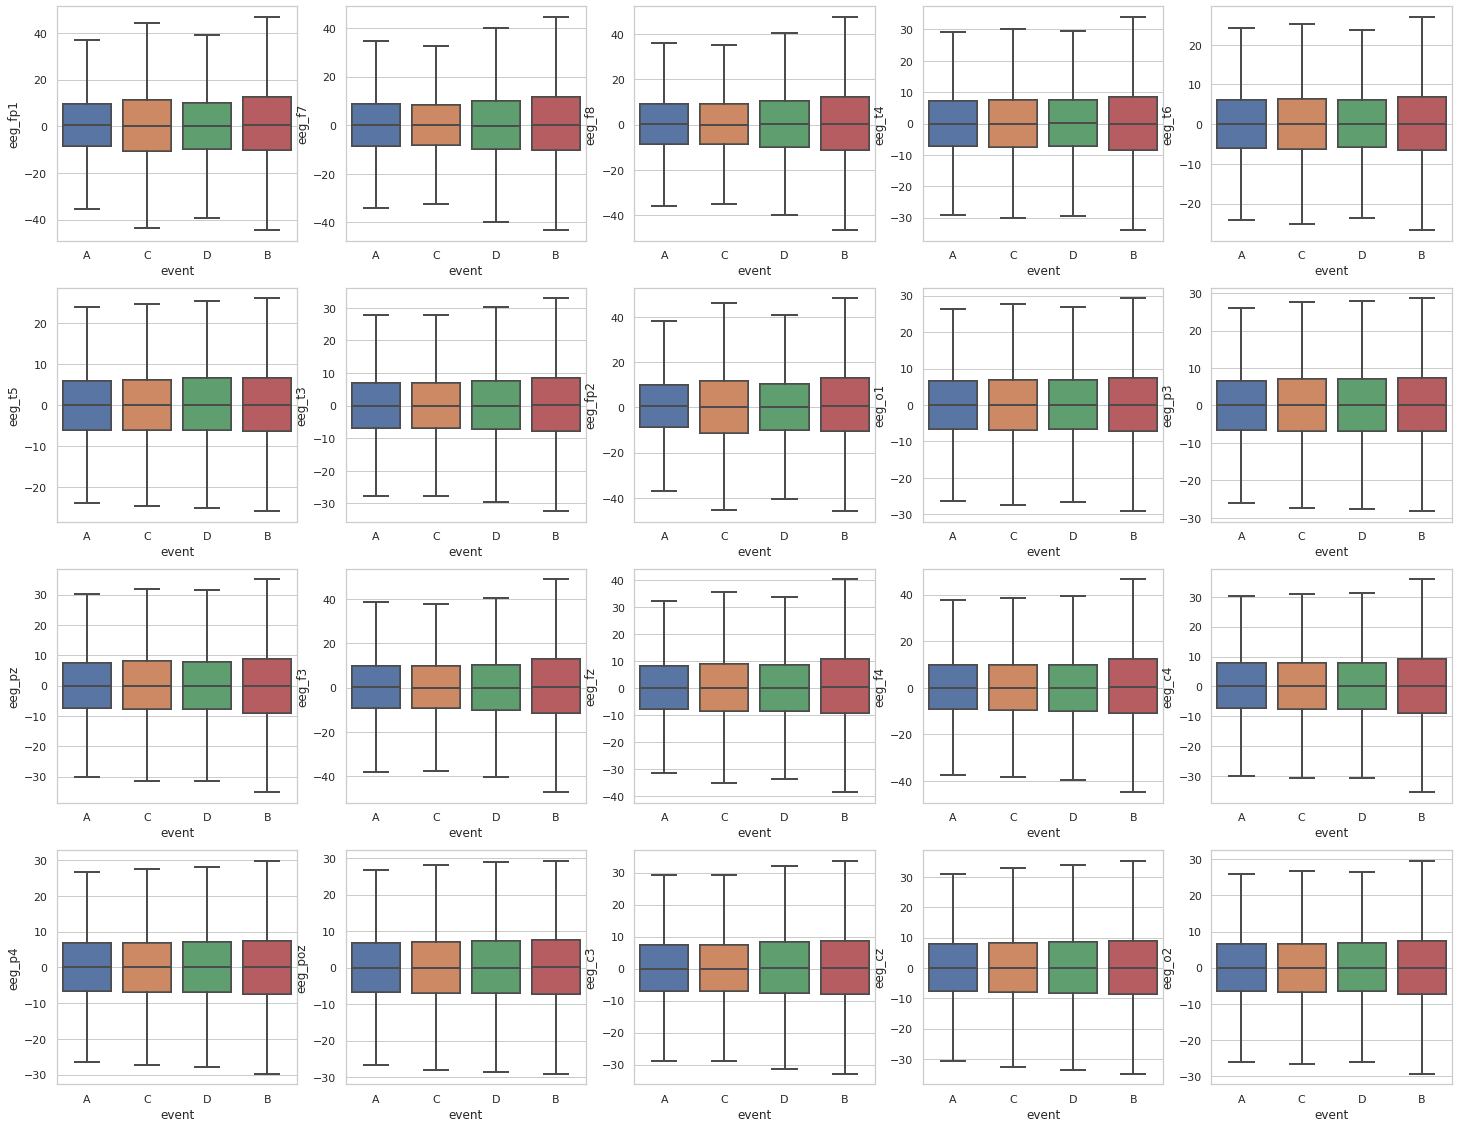

In [ ]:
plt.figure(figsize=(25,25))
plt.title("All EGG Reading Box Plot ",fontsize=20)
for i in tqdm(range(len(eeg_features))):
  for i,egg in enumerate(eeg_features):
    plt.subplot(5,5,i+1)
    sns.boxplot(x='event',y=egg,data=train_data,showfliers=False)
plt.show()

100%|██████████| 20/20 [47:59<00:00, 143.97s/it]


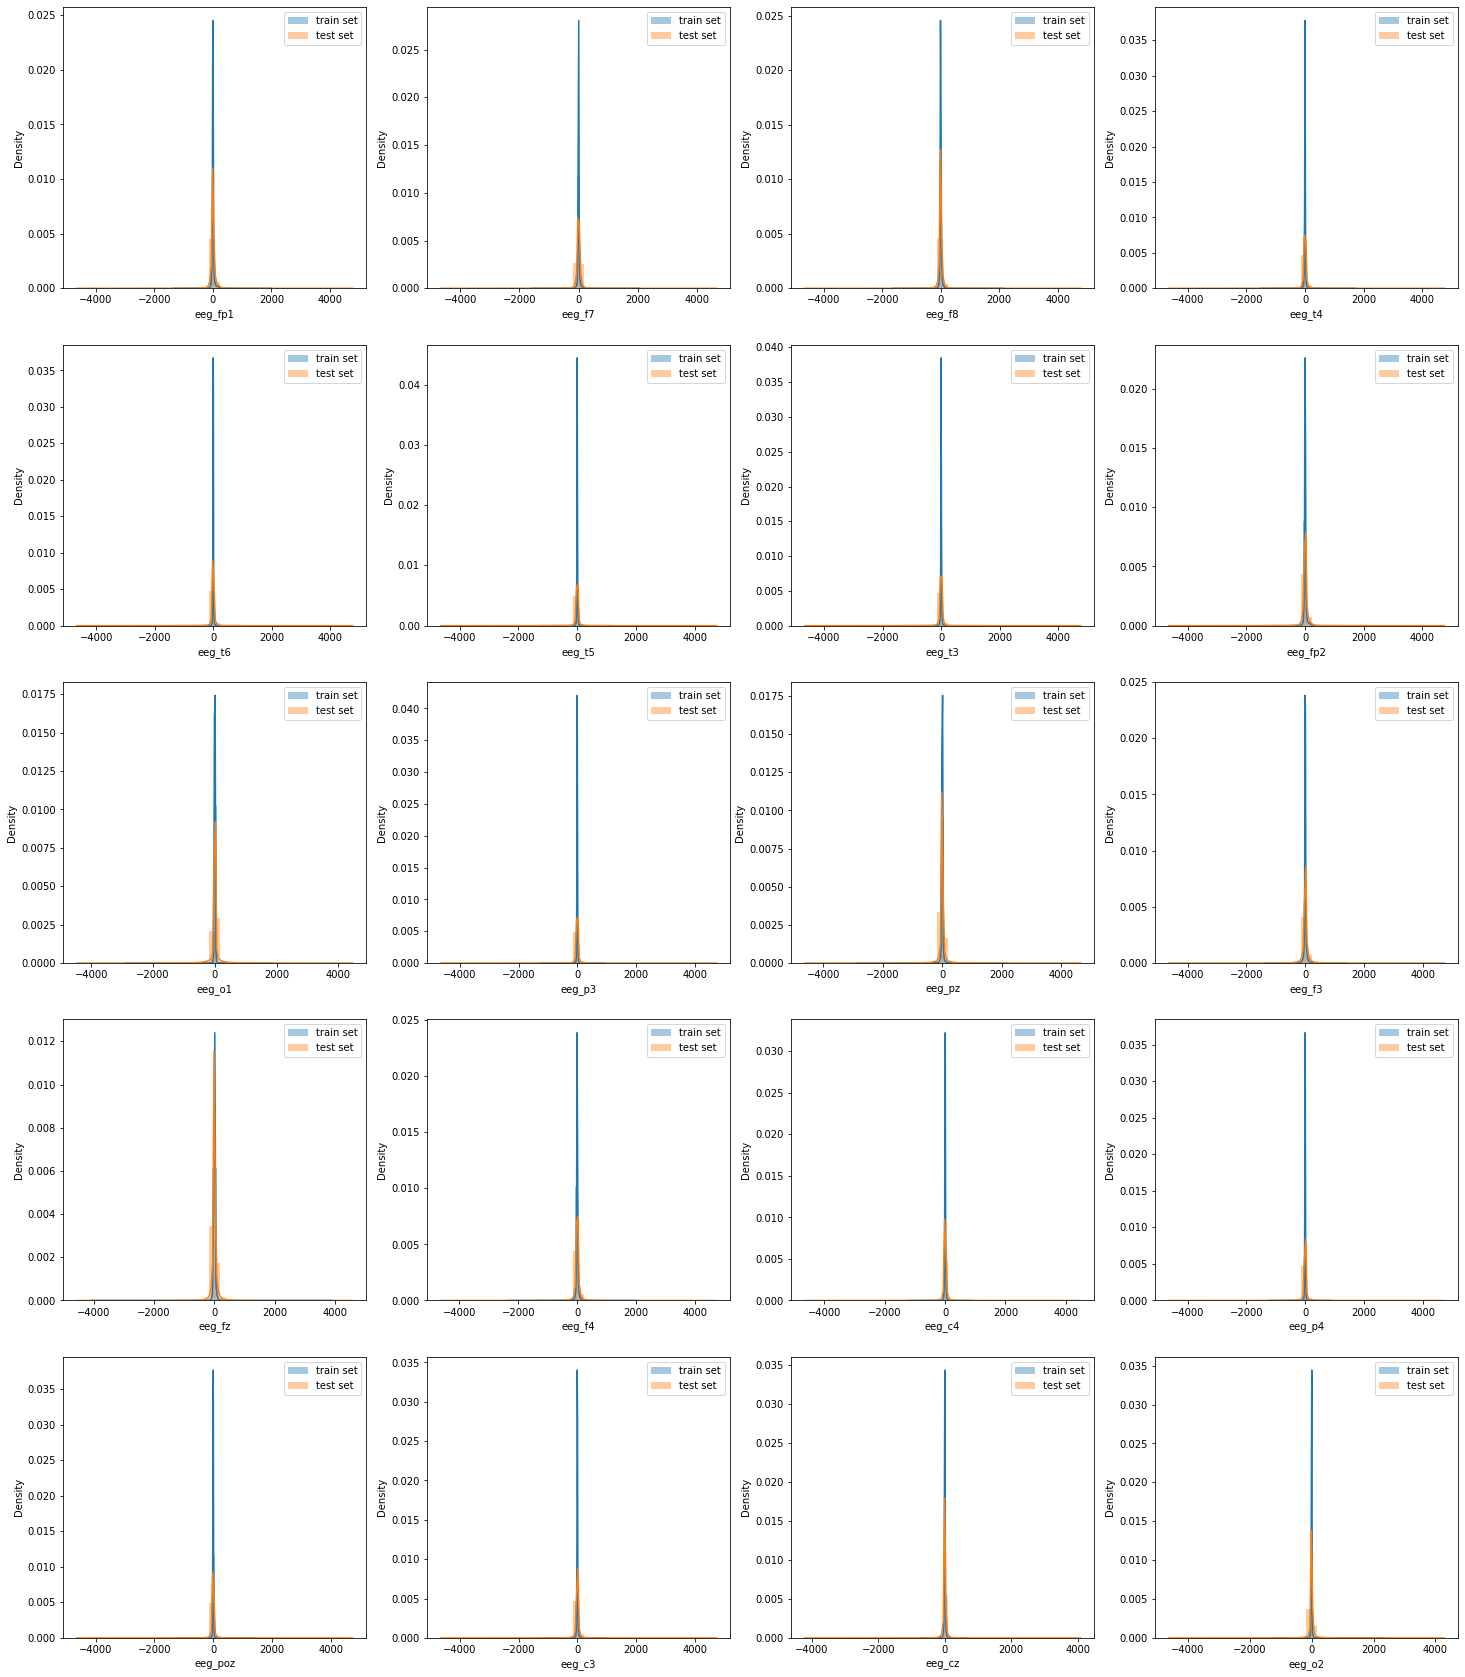

In [ ]:
plt.figure(figsize=(25,30))
frame=0
for i in tqdm(range(len(eeg_features))):
  frame+=1
  plt.subplot(5,4,frame)
 
  sns.distplot(train_data[eeg_features[i]], label='train set')
  sns.distplot(test_data[eeg_features[i]], label='test set')
  plt.legend()
plt.show()

* From the EEG violin plots, we can say that the values of each EEG signals are almost with mean value as 0 and variance is less than 500. So we can consider it to be nearly normally distributed.
* We can also observe that mostly all the events are lying in the almost same range so we can't simply put some value as a threshold and use it to classify the events.
* From box plot most of the features are highly overlapping
* We can see above both Train and Test EGG data follow about to normal distribution but test data have a bigger peak at zero(0) and more variance in test data

## Some more plots

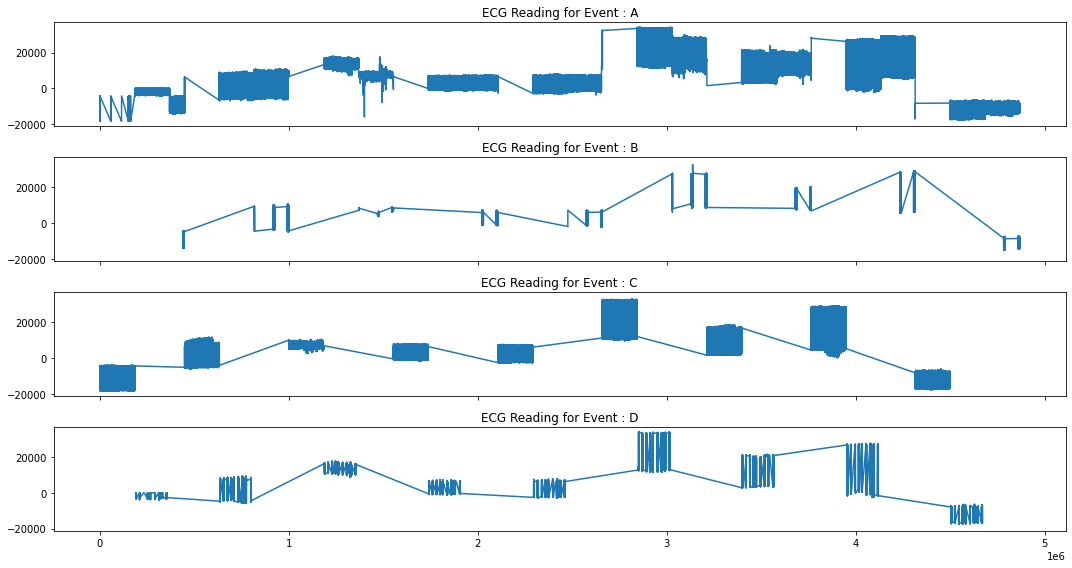

In [8]:
#ECG
fig, axs = plt.subplots(4, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)
events=['A','B','C','D']
for i,event in enumerate(events):
    axs[i].plot(train_data.loc[train_data['event']==event]['ecg'])
    axs[i].set_title('ECG Reading for Event : {}'.format(event))
fig.tight_layout()    
plt.show()

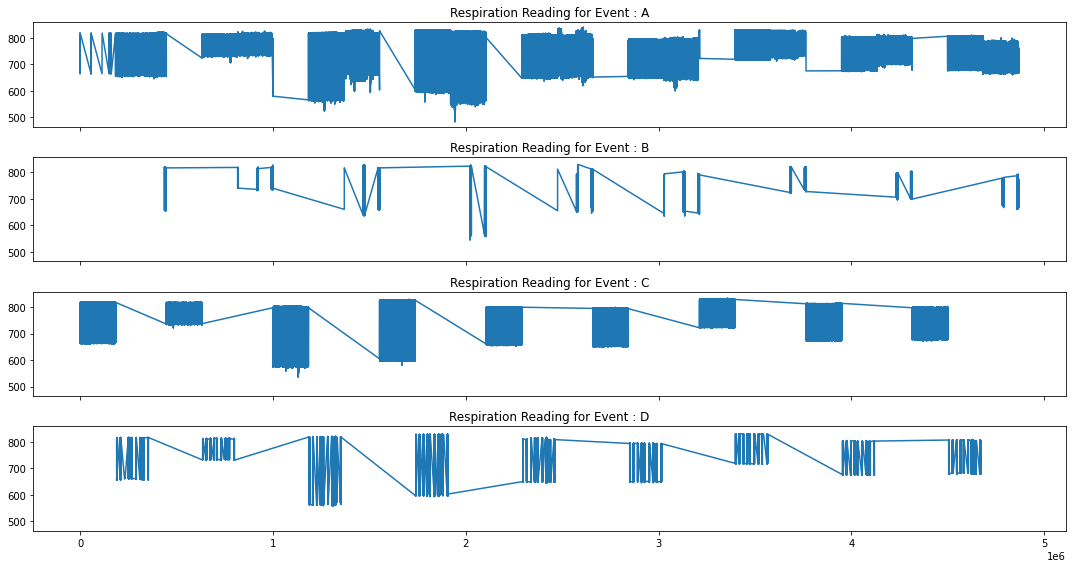

In [10]:
#RESPIRATION
fig, axs = plt.subplots(4, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)
events=['A','B','C','D']
for i,event in enumerate(events):
    axs[i].plot(train_data.loc[train_data['event']==event]['r'])
    axs[i].set_title('Respiration Reading for Event : {}'.format(event))
fig.tight_layout()    
plt.show()

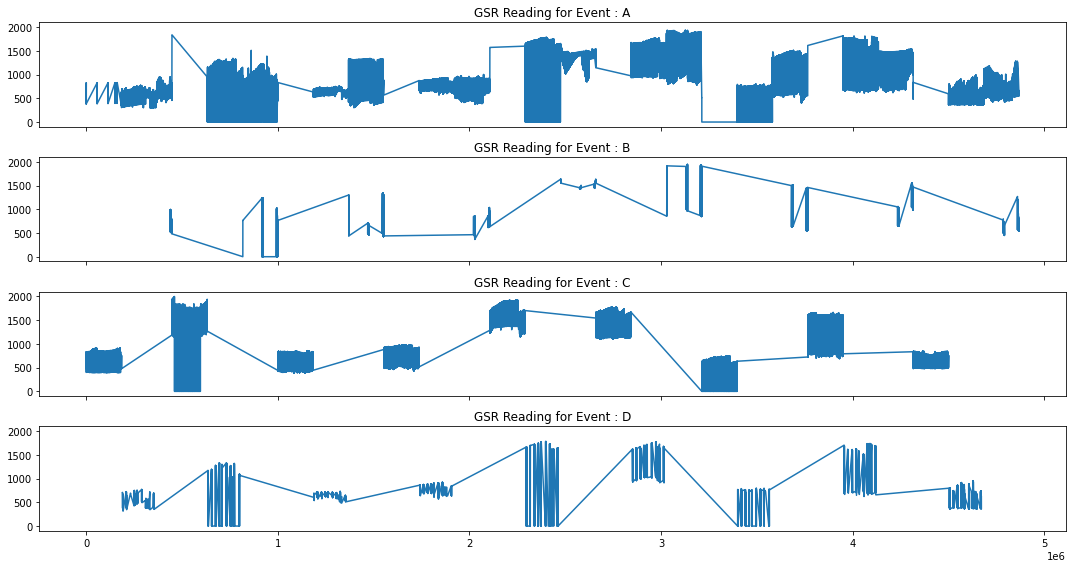

In [11]:
#GSR
fig, axs = plt.subplots(4, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)
events=['A','B','C','D']
for i,event in enumerate(events):
    axs[i].plot(train_data.loc[train_data['event']==event]['gsr'])
    axs[i].set_title('GSR Reading for Event : {}'.format(event))
fig.tight_layout()    
plt.show()

* Every event have different shape as we can easily distinguish.


# Observation from EDA


* There are 27 features are present in the dataset.
* There is an imbalance in the given dataset.
* There are no missing values in this dataset
* ECG violin plot has about the same data we are not getting much information from that but if we see signal reading plots which show as different for every event.
* EEG Reading violin plot is about the same for every event, if we see EEG signal plot we will differ between every event on the different electrode on the scalp.
* Respiration and GSR have about the same story as ECG and EEG plots


